In [17]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from scipy.io import loadmat

import math


In [18]:
# data = np.loadtxt('MackeyGlass_t17.txt')

In [19]:
# Constants
density = 1

# generate the ESN reservoir
inSize = outSize = 10
resSize = 10 # reservoir size
alpha = 1 # leaking rate

random_state=42
#random.seed(42)

dataLen = 10000
trainLen = 8000

In [20]:
#W = np.random.rand(10,10)-0.5 

In [21]:
# FIXME: move to sparse matrix
def spectral_radius(matrix):
    '''
    Calculate spectral radius of matrix. 
    Spectral radius is max absolute eigenvalue.
    '''
    # FIXME: remove code below
    inner = matrix
    eigenvalues = np.linalg.eig(inner)[0]
    return max(abs(eigenvalues))

In [22]:
def build_reservoir():
    # FIXME: move to spartial
    # include bias term
    Win =  sparse.rand(resSize, inSize + 1, density=1, random_state=random_state)
    Win -= (Win.sign()*0.5)
    
    W = sparse.rand(resSize, resSize, density=density, random_state=random_state)
    W -= W.sign()*0.5
    W *= 1.25/spectral_radius(W.toarray())
    return (Win.toarray(), W.toarray())
    #return (Win, W)

In [23]:
Win, W = build_reservoir()

In [24]:
my_data = np.genfromtxt('train.cv', delimiter=',')

3.0


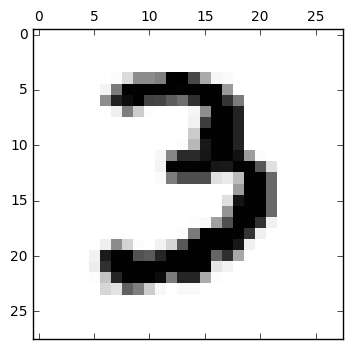

In [25]:
row = 10
num = my_data[row, :][0]
pic=my_data[row, :][1:].reshape(28,28)
print(num)
plt.matshow(pic, cmap='Greys')

In [61]:
import scipy

def scale(data, newSize=16):
    examples, length = my_data.shape
    newLength = newSize**2
    newData = np.ndarray((examples, newLength))
    oldSize = int(length**(0.5))
    for row in range(examples):
        pic=data[row, :][1:].reshape(oldSize,oldSize)
        scaled = scipy.misc.imresize(pic, (newSize,newSize), interp='bicubic')
        newData[row,:] = scaled.reshape(newLength)
    return newData


28

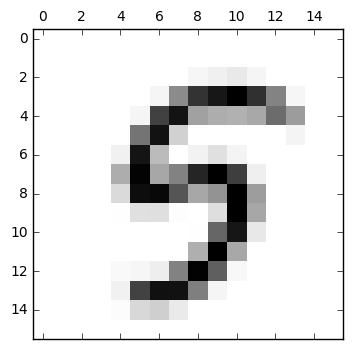

In [60]:
plt.matshow(data[9,:].reshape(16,16), cmap='Greys')

In [12]:
def extract(row):
    num = row[0]
    pic = row[1:]
    return (num, pic)

def encode2vec(num):
    converted = int(num) % 10
    result = np.zeros((10,), dtype='int')
    result[converted] = 1
    return result

def normalize_pixel(pixels):
    return pixels/256

Y = np.ndarray((8816,1), dtype='int')
Y_t = np.ndarray((8816,10), dtype='int')
U = np.ndarray((8816,784))
counter = 0
for i in range(1,42001):
    num, pic = extract(my_data[i, :])
    if int(num) not in [1,0]:
        continue
    Y[counter, :] = int(num)
    U[counter, :] = normalize_pixel(pic)
    counter +=1
    
X_train, X_test, y_train, y_test = train_test_split(U, Y, test_size=0.8, random_state=42)
y_v_train = np.ndarray((y_train.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_train]))
y_v_test = np.ndarray((y_test.shape[0], 10), dtype=int, buffer=np.array([encode2vec(y) for y in y_test]))
counter

8816

In [13]:
# load the data
trainLen = 2000
testLen = 2000
initLen = 0 # Practical ESN 4.5

# generate the ESN reservoir
sequenceLength=784
inSize = 1
outSize = 10
resSize = 1000
a = 0.1 # leaking rate

In [14]:
Win, W = build_reservoir()

In [61]:
# for i in range(0,10000):
#     data[i] = abs(math.sin(math.log(1+i**(0.5))))
# plt.plot(data[0:10000])

In [15]:
X_tr = X_train
X_train = X_train[0: 100, :]
X_ts = X_test
X_test = X_test[0: 100, :]

In [16]:
# Our time of interest is 784, when all pixels was read by reservoir 
examples, sequenceLength = X_train.shape

#X = np.zeros((1+inSize+resSize,examples))
X = np.zeros((examples, 1+resSize))
# set the corresponding target matrix directly
#Yt = data[None,initLen+1:trainLen+1] 


# run the reservoir with the data and collect X

for e in range(examples):
    picture = X_train[e]
    # build reservoir for this example
    x = np.zeros((resSize,1))
    for pic in picture:
        u = pic
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    X[e,:] = np.vstack((1,x))[:,0]
    print(e, end='\r')

# for t in range(trainLen):
#     u = data[t]
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     if t >= initLen:
#         X[:,t-initLen] = np.vstack((1,u,x))[:,0]
        
# reg = 1e-1  # regularization coefficient
# X_T = X.T
# Wout = np.dot( np.dot(Yt,X_T), np.linalg.inv( np.dot(X,X_T) + \
#     reg*np.eye(1+inSize+resSize) ) ) 


# Y = np.zeros((outSize,testLen))
# u = data[trainLen]
# for t in range(testLen):
#     x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
# #     x = np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
#     y = np.dot( Wout, np.vstack((1,u,x)) )
#     Y[:,t] = y
#     # generative mode:
#     u = y
#     ## this would be a predictive mode:
#     #u = data[trainLen+t+1] 
    
# errorLen = 1000
# mse = np.sum( np.square( data[trainLen+1:trainLen+errorLen+1] - Y[0,0:errorLen] ) ) / errorLen
# print('MSE = ' + str( mse ))


# plt.figure(1).clear()
# plt.plot( data[trainLen+1:trainLen+testLen+1], 'g' )
# plt.plot( Y.T, 'b' )
# plt.title('Target and generated signals $y(n)$ starting at $n=0$')
# plt.legend(['Target signal', 'Free-running predicted signal'])


# plt.figure(2).clear()
# plt.plot( X[0:20,0:200].T )
# plt.title('Some reservoir activations $\mathbf{x}(n)$')

In [111]:
reg = 1e-6  # regularization coefficient
X_T = X.T
Yt = y_v_train[0:100]

In [112]:
Wout = np.dot( np.dot(Yt.T,X), np.linalg.inv( np.dot(X_T,X) + \
    reg*np.eye(1+resSize) ) ) 

In [118]:
# Our time of interest is 784, when all pixels was read by reservoir 
examples, sequenceLength = X_test.shape


# run the reservoir with the data and collect X
predicts = []
for e in range(examples):
    picture = X_test[e]
        # build reservoir for this example
    x = np.zeros((resSize,1))
    for pic in picture:
        u = pic
        x = (1-a)*x + a*np.tanh( np.dot( Win, np.vstack((1,u)) ) + np.dot( W, x ) )
    y = np.dot( Wout, np.vstack((1,x)) )
    predicts.append(y)
    print(e, end='\r')


In [114]:
y_test[0:100,0]

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [123]:
np.array([np.argmax(predict) for predict in predicts])

array([1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 1, 1])

In [2]:
X_train

NameError: name 'X_train' is not defined